In [72]:
#Importing dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

In [3]:
data=pd.read_excel('/content/CocaCola_Sales_Rawdata.xlsx')
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
data.shape

(42, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [6]:
# Find unique data of every feature
data.nunique()

Quarter    42
Sales      42
dtype: int64

#Feature Engineering

Convert quarters into years

In [7]:
data['Quarter_Year']=data['Quarter'].str.split('_').apply(lambda x:' 19' .join (x[:]))
data.head()

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987


#Now, we Convert Quarter year into Date:

In [8]:
data['Date']=(pd.to_datetime(data['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
data.head()

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01


In [9]:
#Extractng the quarters and putting in column
data['Quarters']=0

for i in range(42):
    n=data['Quarter'][i]
    data['Quarters'][i]=n[0:2]
           
data.head()

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1


In [10]:
q_dummy=pd.DataFrame(pd.get_dummies(data['Quarters']))
data2=pd.concat((data,q_dummy),axis=1)
data2.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [11]:
#Dropping the (Quarter) column
data2.drop(['Quarter','Quarter_Year'],axis=1,inplace=True)
data2.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


In [12]:
#Date as Date-time index for the dataframe
data2.set_index('Date',inplace=True)
data2.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [13]:
data2.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


Seperating Month and year for visualisation amd removinf meaningful insight of the data.

In [14]:
data['Date']=pd.to_datetime(data.Date,format='%b-%y')
data['Month']=data.Date.dt.strftime('%b')
data['Year']=data.Date.dt.strftime('%Y')
data.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Month,Year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987


<Figure size 1080x720 with 0 Axes>

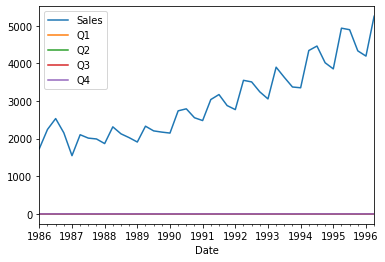

In [15]:
#Vizualizing Dataset
from matplotlib import pyplot
plt.figure(figsize=(15,10))
data2.plot()
pyplot.show()

Histogram and Density Plots

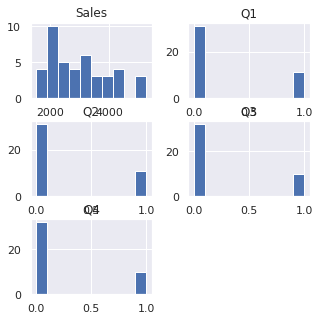

<Figure size 1080x720 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
data2.hist()
plt.figure(figsize=(15,10))
pyplot.show()


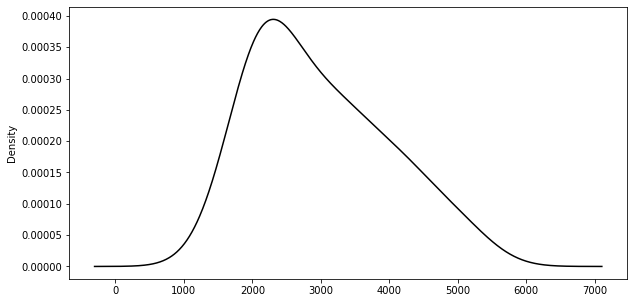

In [16]:
# density plot
ax = plt.axes()
ax.set_facecolor("White")
data['Sales'].plot(kind='kde',figsize=(10,5),color='Black')

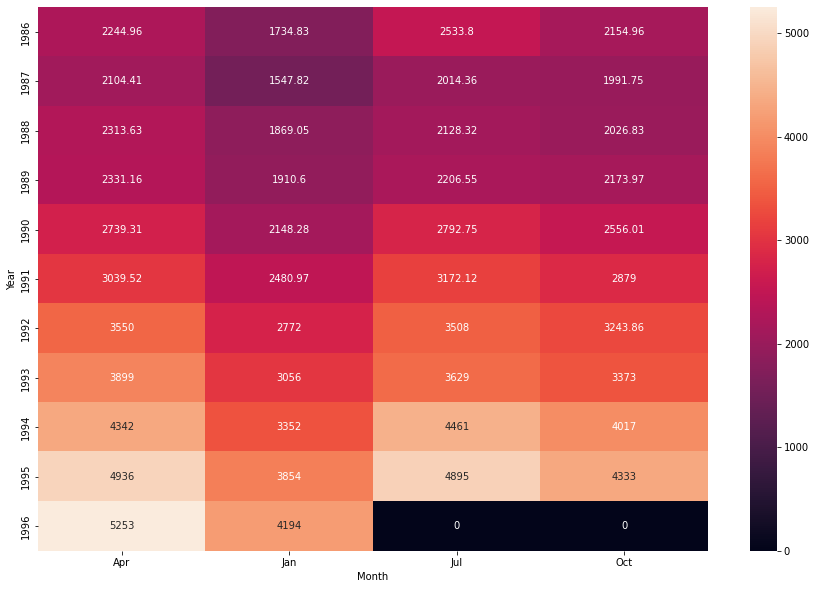

In [17]:
# Heatmap
import seaborn as sns
plt.figure(figsize=(15,10))
y_m=pd.pivot_table(data=data,values='Sales',index='Year',columns='Month',aggfunc="mean",fill_value=0)
sns.heatmap(y_m,annot=True,fmt='g')

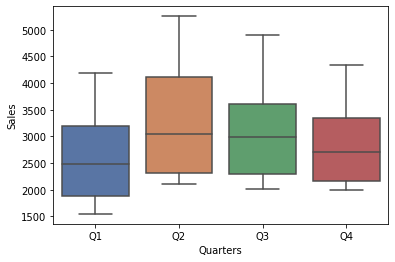

In [18]:
# boxplot of Quarters Vs. Sales
import seaborn as sns
ax = plt.axes()
ax.set_facecolor("white")
sns.set(rc={'figure.figsize':(15,8)})
sns.boxplot(x="Quarters",y="Sales",data=data2)

Box Plot of each year month intervals

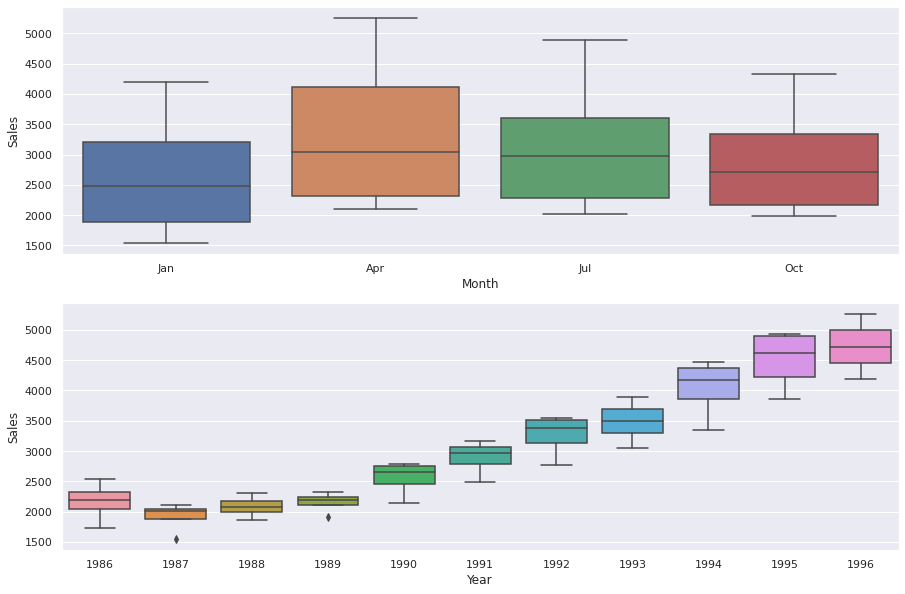

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(211)
sns.boxplot(x='Month',y="Sales",data=data)
plt.subplot(212)
sns.boxplot(x='Year',y="Sales",data=data)

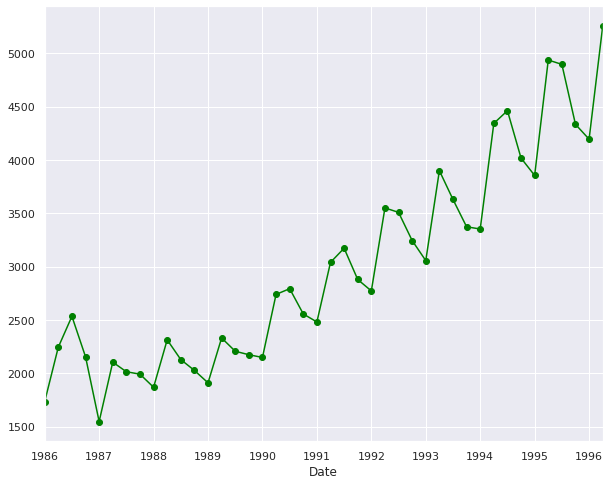

In [20]:
data2['Sales'].plot(figsize=(10, 8),color='green',marker='o')
plt.show()

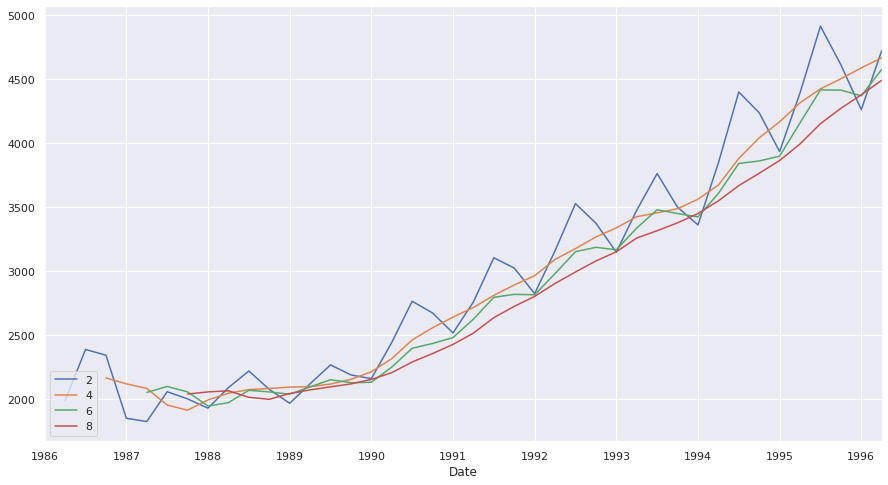

In [21]:
for i in range(2,10,2):
    data2["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

#Lag plot

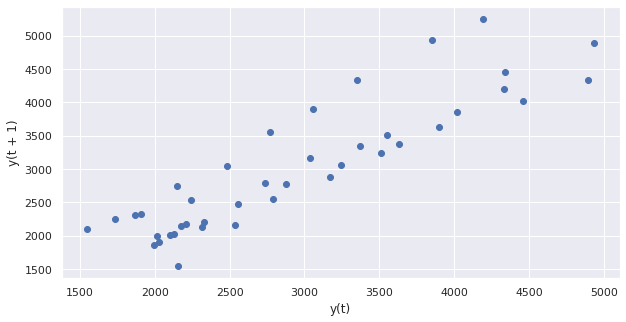

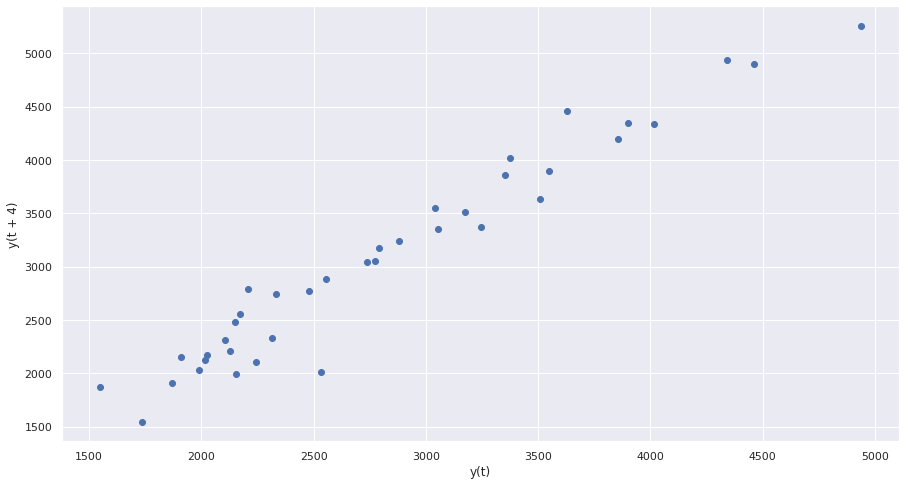

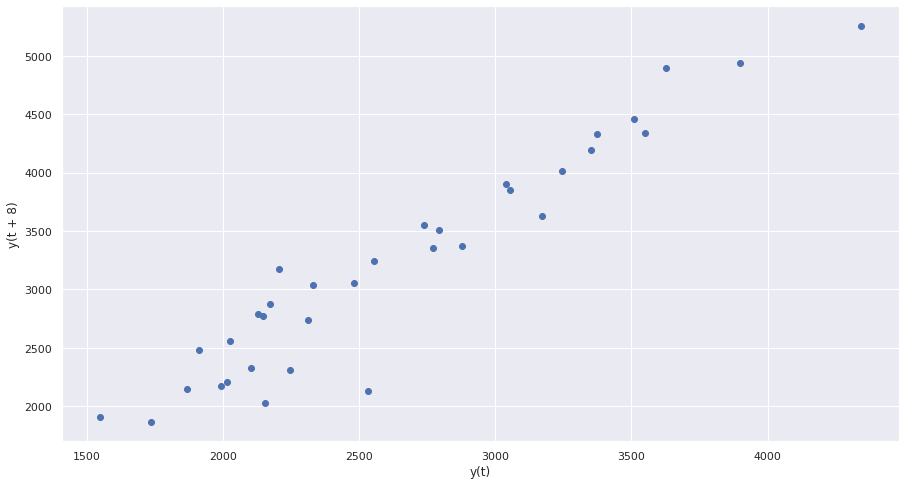

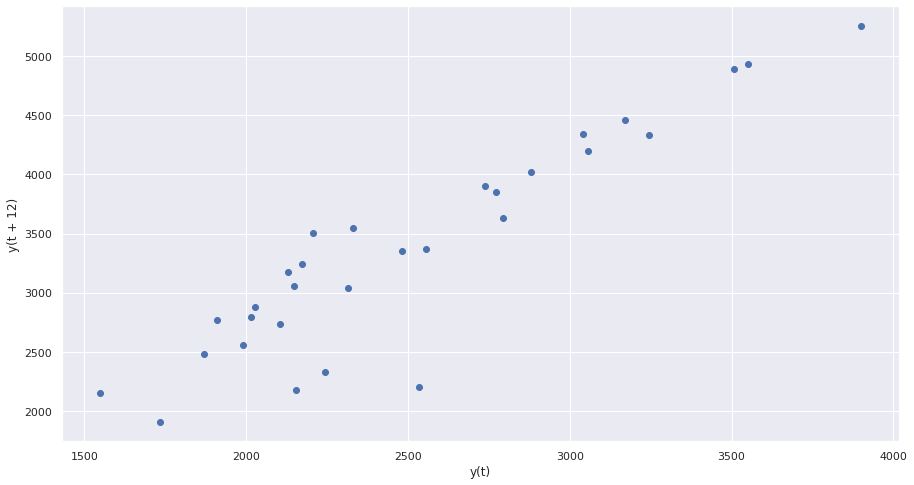

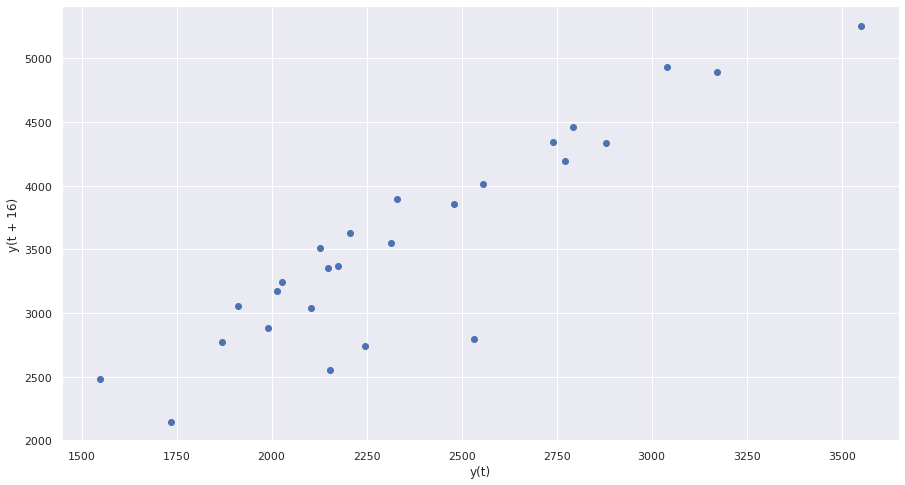

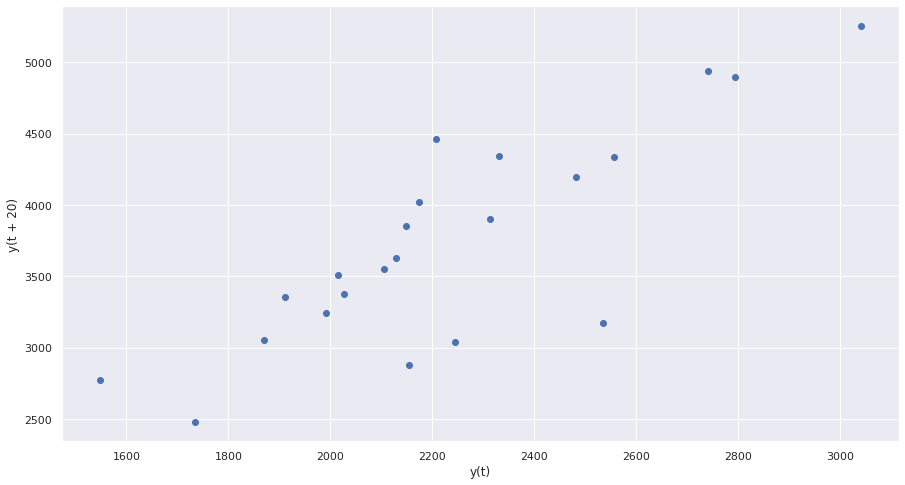

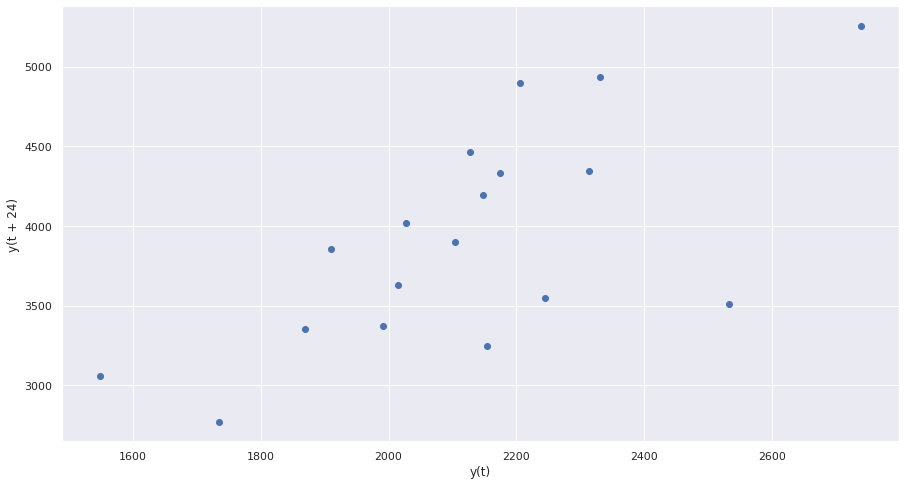

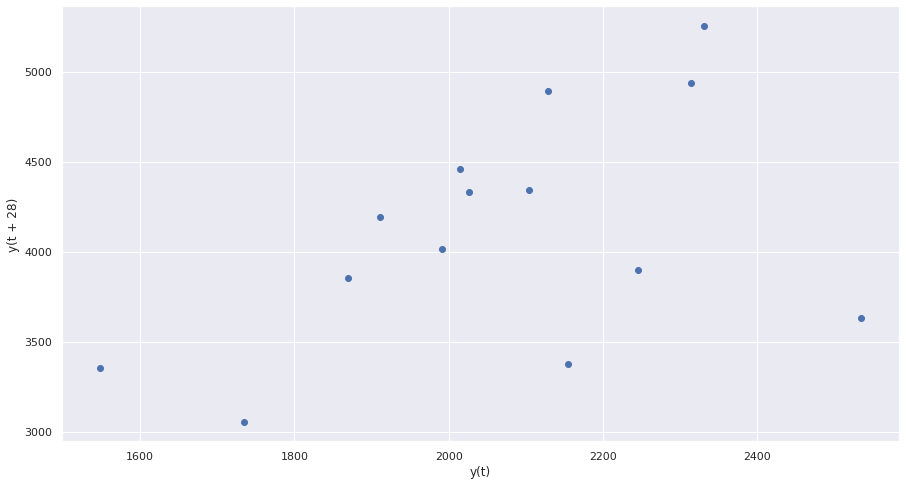

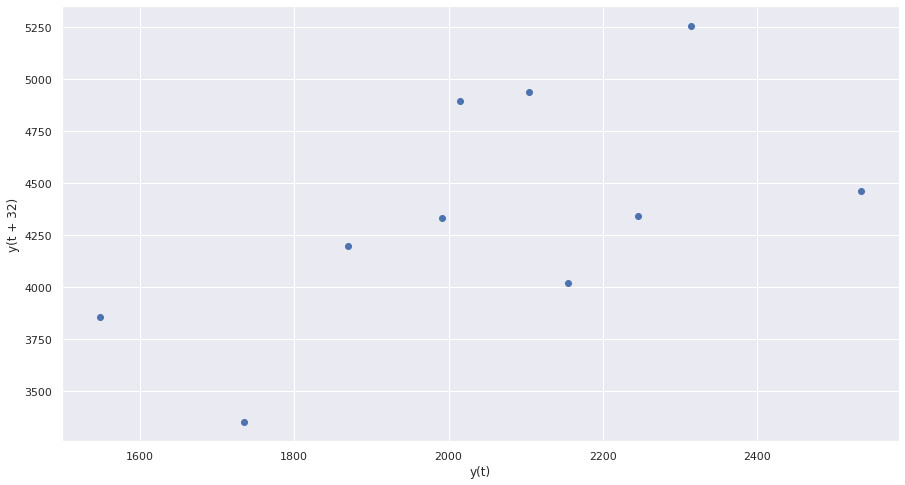

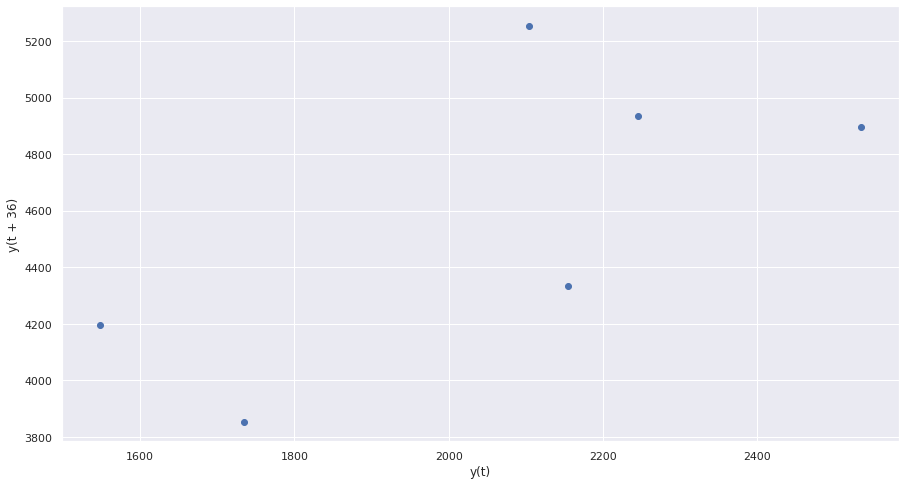

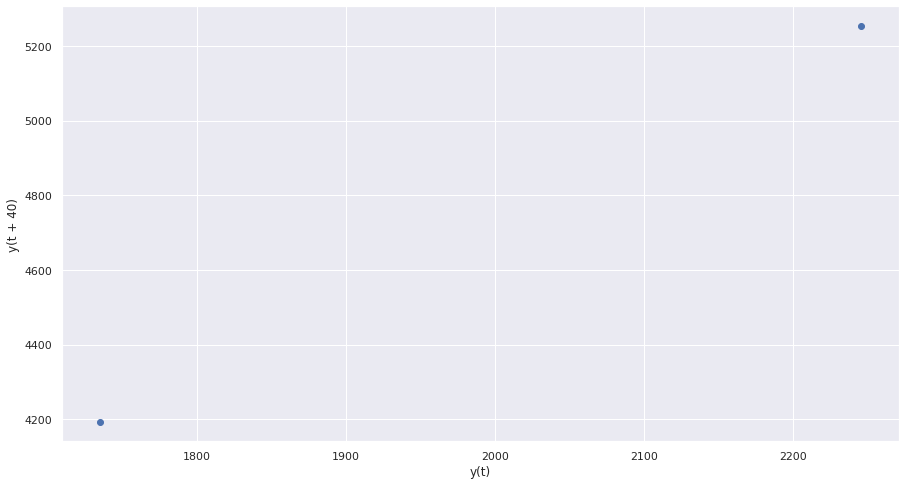

In [22]:
from pandas.plotting import lag_plot
plt.figure(figsize=(10,5))

   
for i in [1,4,8,12,16,20,24,28,32,36,40]:
    lag_plot(data.Sales,lag=i)
    plt.show()

ACF Plots amd PACF plots

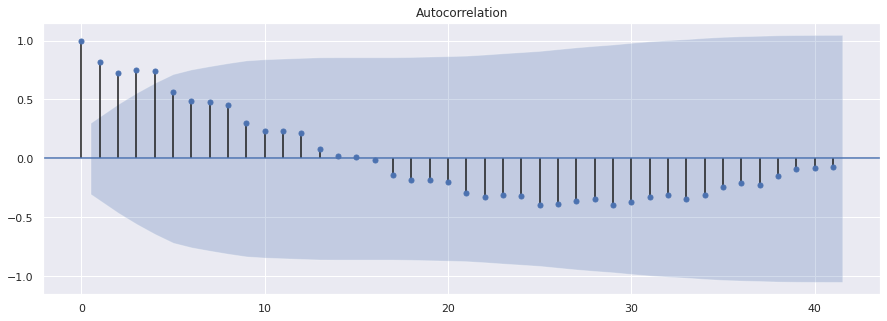

In [23]:
# ACF(Auto-Corelation Function)
import statsmodels.graphics.tsaplots as tsa_plots 
with plt.rc_context():
    plt.rc('figure',figsize=(15,5))
    tsa_plots.plot_acf(data['Sales'],lags=41)
    plt.show()

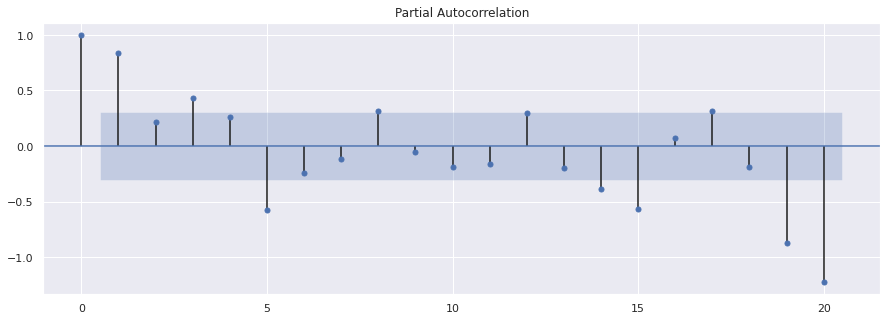

In [24]:
# Partial Autocorrelation Function (PACF)
import statsmodels.graphics.tsaplots as tsa_plots 
with plt.rc_context():
    plt.rc('figure',figsize=(15,5))
    tsa_plots.plot_pacf(data['Sales'],lags=20)
    plt.show()

#Time Series Decomposition

Additive Seasonal Decomposition



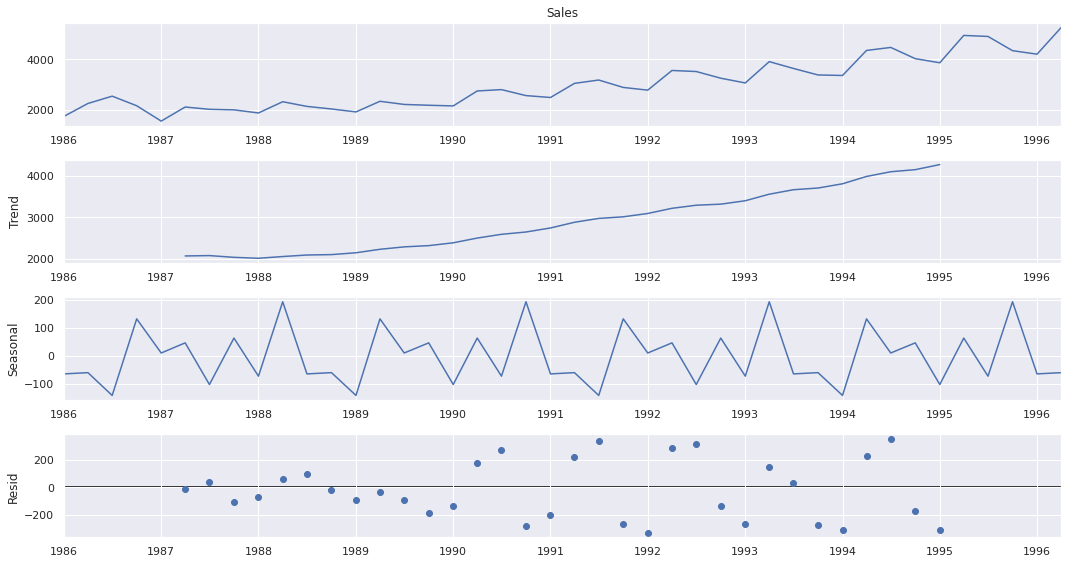

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime,time
ts_add = seasonal_decompose(data2.Sales,model="additive",period=10)
fig = ts_add.plot()
plt.show()

Multiplicative

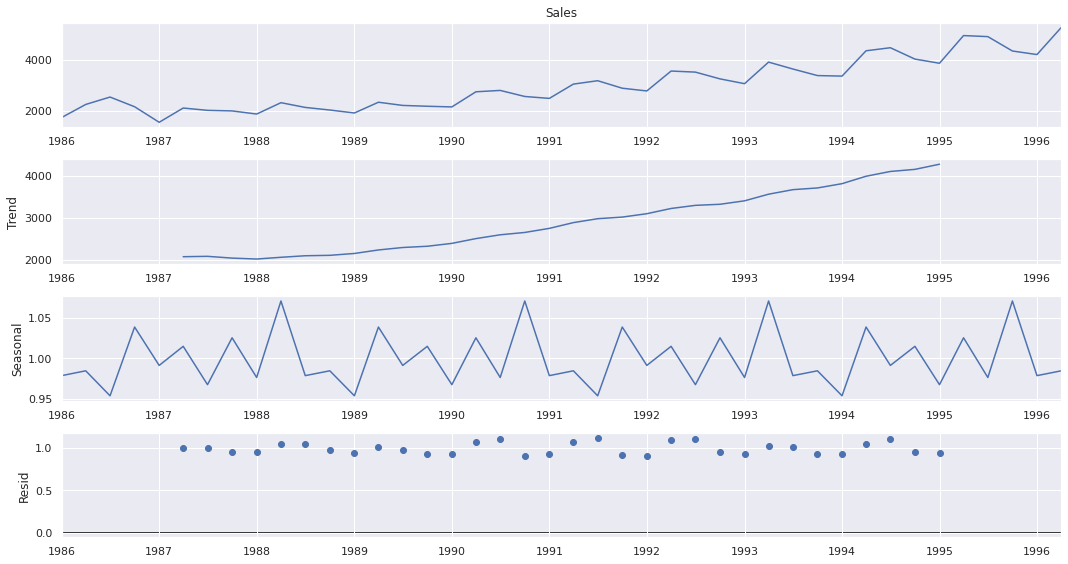

In [26]:
ts_mul = seasonal_decompose(data2.Sales,model="multiplicative",period=10)
fig = ts_mul.plot()
plt.show()

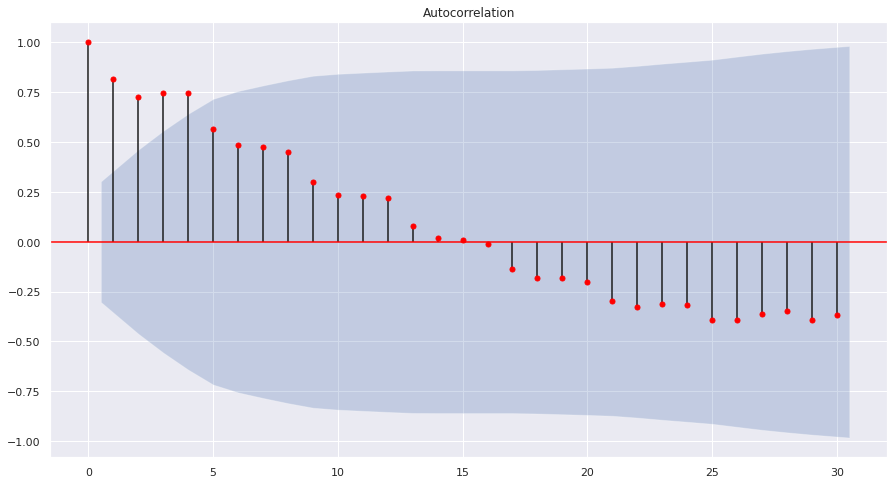

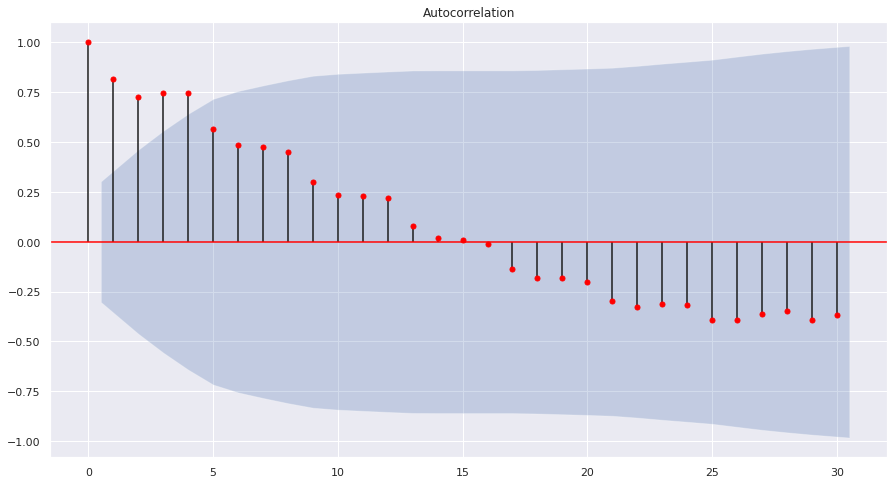

In [27]:
tsa_plots.plot_acf(data2.Sales, lags=30,color='red')

Forcasting Data Driven

#Sampling

Linear Interpolation                                                       
Now we draw a straight line which joining the next and previous points of  the missing values in the data.                                            
Sampling w.r.t month

In [28]:
data2.columns

Index(['Sales', 'Quarters', 'Q1', 'Q2', 'Q3', 'Q4'], dtype='object')

In [31]:
sampl_month=data2.drop(['Quarters', 'Q1', 'Q2', 'Q3', 'Q4'],axis=1)
sampl_month=sampl_month.resample('M').mean()
sampl_month.head(10)

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,NaN
1986-03-31,NaN
1986-04-30,2244.960999
1986-05-31,NaN
1986-06-30,NaN
1986-07-31,2533.804993
1986-08-31,NaN
1986-09-30,NaN


In [32]:
month=sampl_month.interpolate(method='linear')
month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


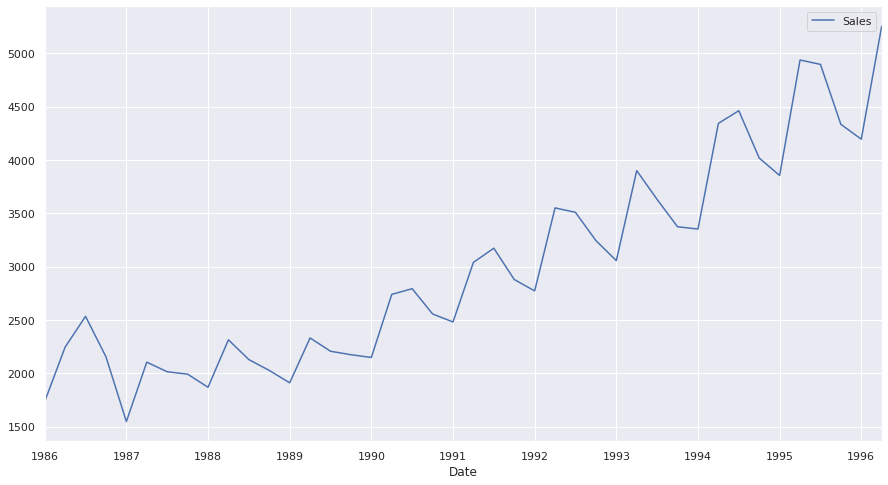

In [33]:
month.plot()
plt.show()

In [34]:
data2=month.copy()
data2.reset_index(inplace=True)
data2['date']=pd.to_datetime(data2['Date'])
data2['year']=data2['Date'].dt.year
data2['month']=data2['Date'].dt.month

data2['week'] =data2['Date'].dt.isocalendar().week
data2['quarter'] = data2['Date'].dt.quarter
data2['day_of_week'] = data2['Date'].dt.day_name()
#data.drop('Date', axis =1 , inplace= True)
data2.head()

,Date,Sales,date,year,month,week,quarter,day_of_week
0,1986-01-31,1734.827000,1986-01-31,1986,1,5,1,Friday
1,1986-02-28,1904.871666,1986-02-28,1986,2,9,1,Friday
2,1986-03-31,2074.916332,1986-03-31,1986,3,14,1,Monday
3,1986-04-30,2244.960999,1986-04-30,1986,4,18,2,Wednesday
4,1986-05-31,2341.242330,1986-05-31,1986,5,22,2,Saturday


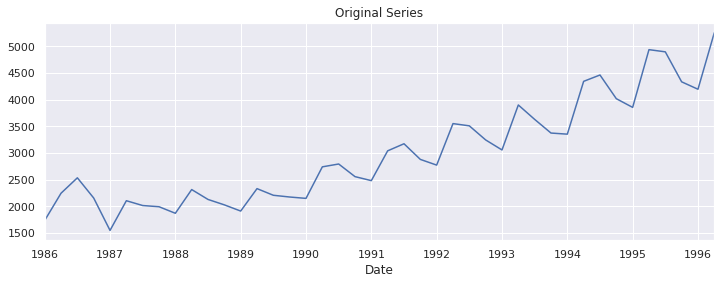

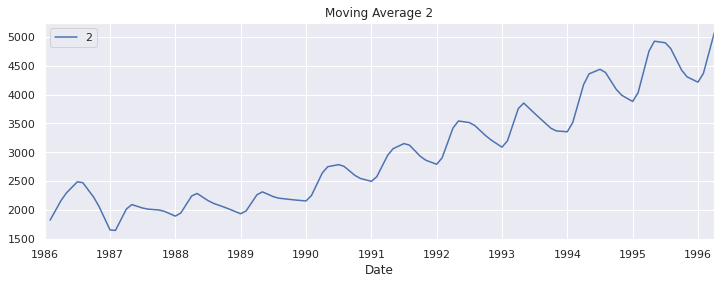

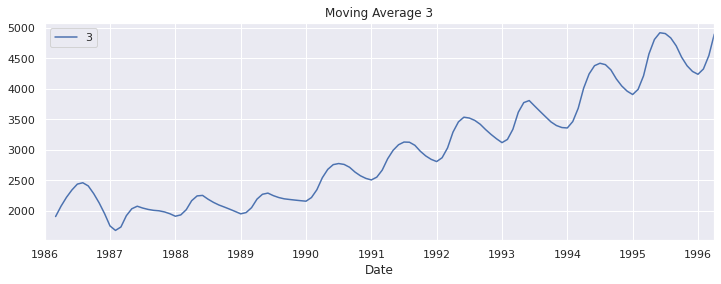

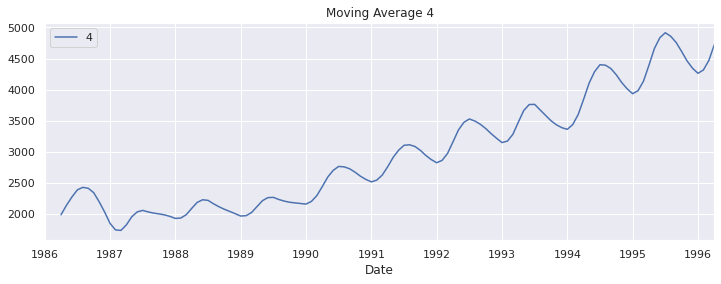

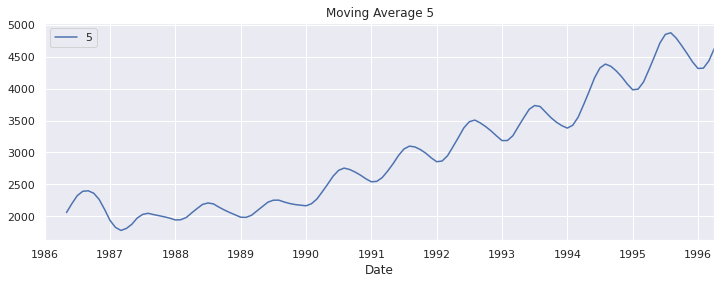

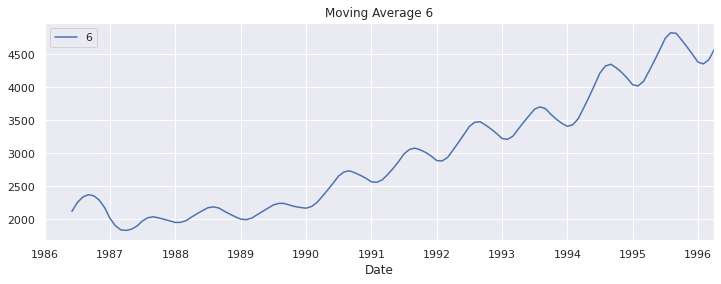

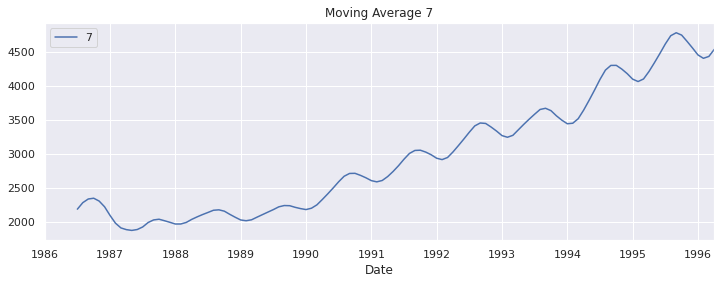

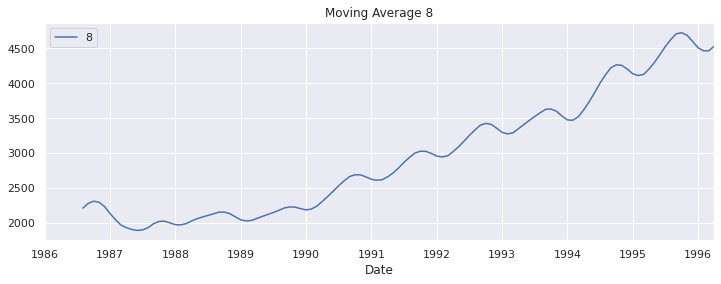

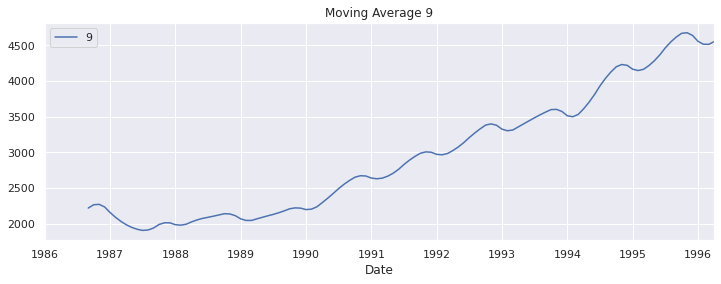

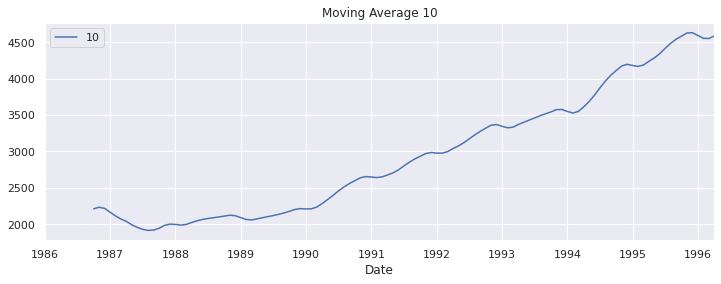

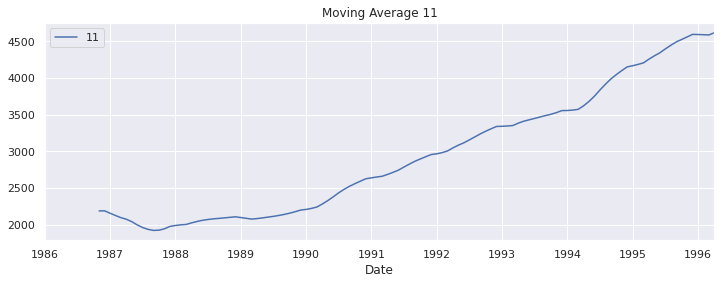

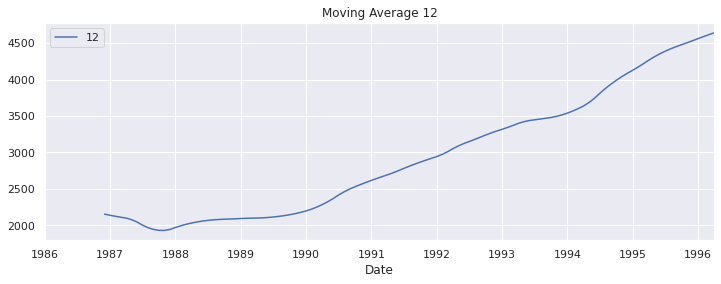

In [35]:
plt.figure(figsize=(12,4))
month['Sales'].plot()
plt.title('Original Series')

for i in [2,3,4,5,6,7,8,9,10,11,12]:
    plt.figure(figsize=(12,4))
    month['Sales'].rolling(i).mean().plot(label=str(i))
    plt.title('Moving Average ' +str(i))
    plt.legend(loc='best')
    plt.show()

#Splitting Data

In [36]:
Train= month[:100]
Test = month[100:]

In [37]:
Train

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1993-12-31,3359.000000
1994-01-31,3352.000000
1994-02-28,3682.000000


In [38]:
Test

,Sales
Date,
1994-05-31,4381.666667
1994-06-30,4421.333333
1994-07-31,4461.000000
1994-08-31,4313.000000
1994-09-30,4165.000000
1994-10-31,4017.000000
1994-11-30,3962.666667
1994-12-31,3908.333333
1995-01-31,3854.000000


In [39]:
print('Train:',Train.index.min(),Train.index.max(),'\n',
'Test:',Test.index.min(),Test.index.max())

Train: 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test: 1994-05-31 00:00:00 1996-04-30 00:00:00


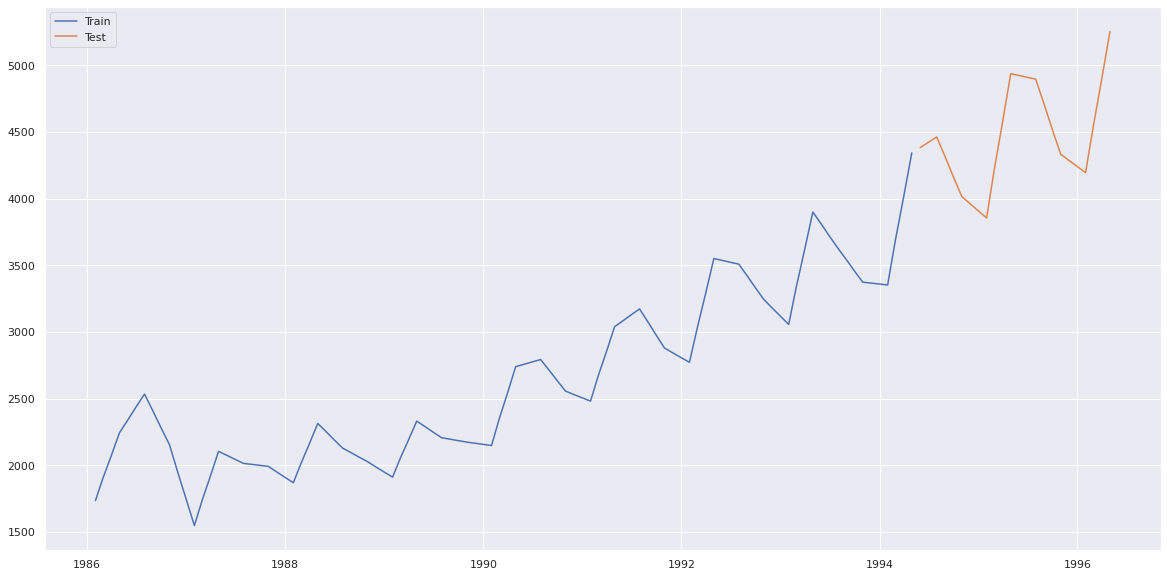

In [40]:
plt.figure(figsize=(20,10))
plt.plot(Train, label='Train')
plt.plot(Test, label='Test')
plt.legend(loc='best')

#Moving Average

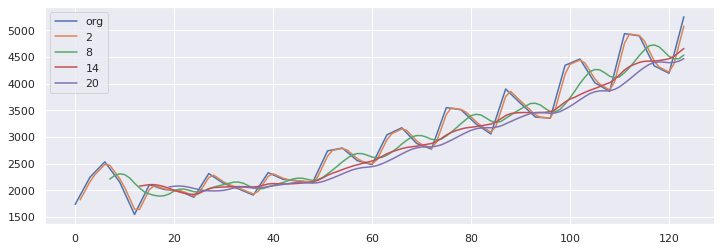

In [41]:
plt.figure(figsize=(12,4))
data2.Sales.plot(label="org")
for i in range(2,24,6):
    data2["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

#Evaluation Metric MAPE

In [42]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [43]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 



#Simple Exponential Method

In [44]:
from math import sqrt
from sklearn.metrics import mean_squared_error
ses_model = SimpleExpSmoothing(Train['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,Test.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,Train))
mape_ses = MAPE(test_pred_ses,Test.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.6197194272254025 
 Train Root Mean Squared Error = 129.3795259055601 
 Test Root Mean Squared Error = 381.95422355078995


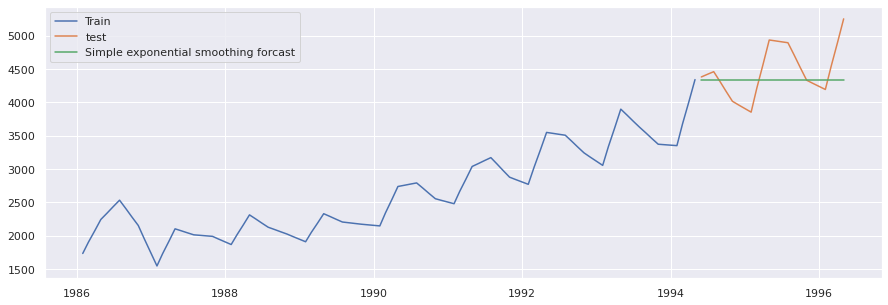

In [45]:
plt.figure(figsize=(15,5))
plt.plot(Train, label='Train')
plt.plot(Test, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

#Holt method

Holt method (Double Exponential)                                           Captures both Level and Trend

In [46]:
dexp_model  = Holt(Train).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,Test.Sales))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,Train))
mape_dexp = MAPE(test_pred_dexp,Test.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 89.49462512277057 
 Train Root Mean Squared Error = 106.0491827859655 
 Test Root Mean Squared Error = 4549.907950839355


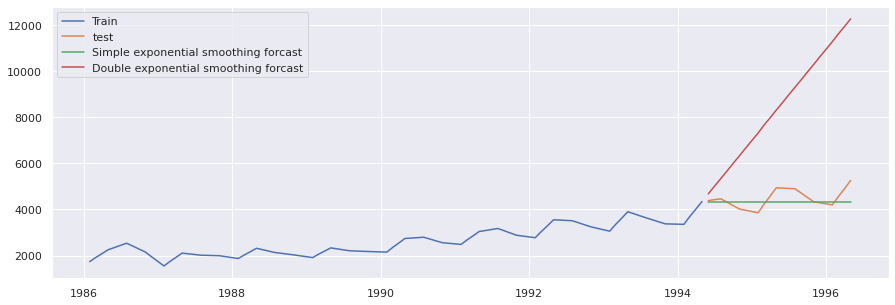

In [47]:
plt.figure(figsize=(15,5))
plt.plot(Train, label='Train')
plt.plot(Test, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

Its too far from simple exponential forecasting                            
We were not able to capture the seasonality. 

## Holts winter exponential smoothing with additive seasonality and trend 

(Triple Exponential)
**Captures Level, Trend and Seasonality.**

In [48]:
texp_add_model  = ExponentialSmoothing(Train,seasonal="add", trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,Test.Sales))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,Train))
mape_ad_texp = MAPE(test_pred_ad_texp,Test.Sales)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 20.371044387697566 
 Train Root Mean Squared Error = 53.248613124153394 
 Test Root Mean Squared Error = 1015.4533579523028


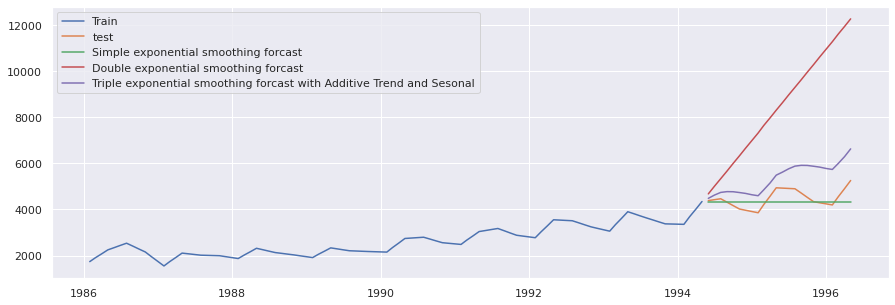

In [49]:
plt.figure(figsize=(15,5))
plt.plot(Train, label='Train')
plt.plot(Test, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

It captures the trend, which we can see that the forecasted values are higher level than the test level.
The peak of the forecasted value is higher than the actual.

#Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [50]:
texp_mul_ad_model  = ExponentialSmoothing(Train,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,Test.Sales))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,Train))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,Test.Sales)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))


Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 2.842742549473639 
 Train Root Mean Squared Error = 43.71702962042127 
 Test Root Mean Squared Error = 168.81527735528465


We can see that the errors have reduced drastically.
Its almost same.

#Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [51]:
texp_ad_mul_model  = ExponentialSmoothing(Train,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,Test.Sales))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,Train))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,Test.Sales)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error = 5.751252565726744 
 Train Root Mean Squared Error = 185.0798155876808 
 Test Root Mean Squared Error = 312.6937921142456


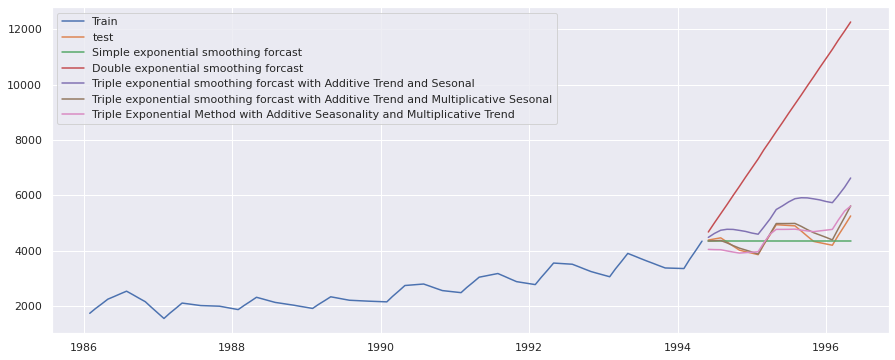

In [52]:
plt.figure(figsize=(15,6))
plt.plot(Train, label='Train')
plt.plot(Test, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

we can see that the last 3 trends are overlapping with test data.

#Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [53]:
texp_mul_model  = ExponentialSmoothing(Train,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,Test.Sales))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,Train))
mape_mul_texp  = MAPE(test_pred_mul_texp,Test.Sales)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error = 8.762201152644389 
 Train Root Mean Squared Error = 59.42394149335137 
 Test Root Mean Squared Error = 460.4773927670168


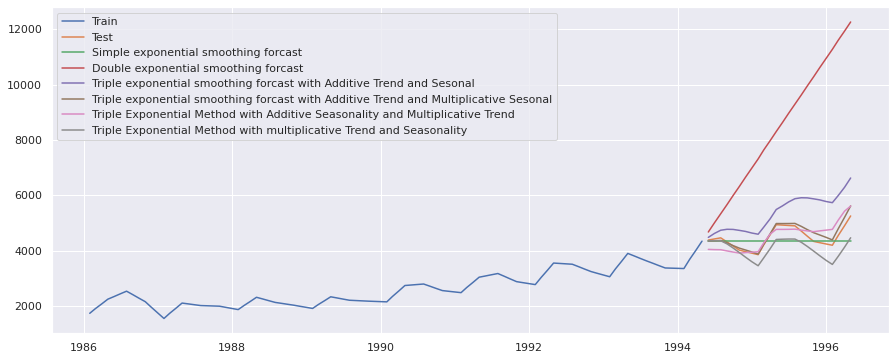

In [54]:
plt.figure(figsize=(15,6))
plt.plot(Train, label='Train')
plt.plot(Test, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

In [55]:

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_mul_ad,43.717030,2.842743,168.815277
1,Triple_Exp_ad_mul,185.079816,5.751253,312.693792
2,Simple_Exp,129.379526,6.619719,381.954224
3,Triple_Exp_mul,59.423941,8.762201,460.477393
4,Triple_Exp_ad,53.248613,20.371044,1015.453358
5,Double_Exp,106.049183,89.494625,4549.907951


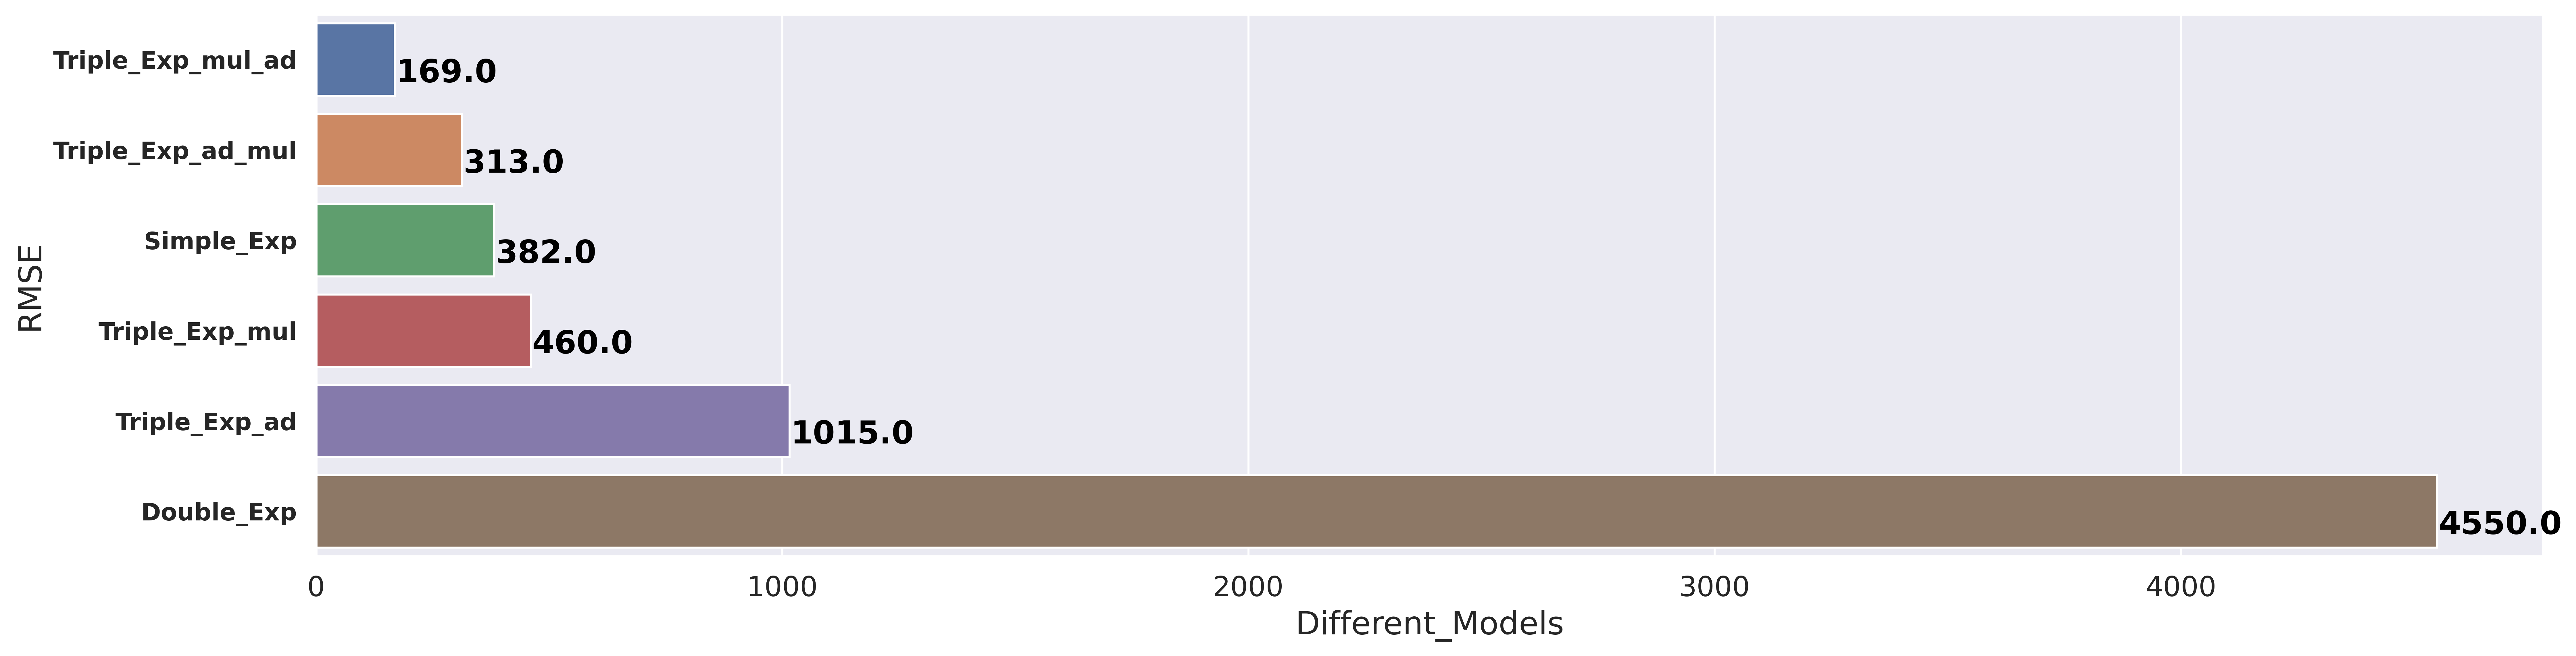

In [56]:
f, axe = plt.subplots(1,1, figsize=(20,5), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

#Autoregressive Integrated Moving Averages (ARIMA)

Test of Stationarity,
As we have quarterly data the window size for moving average is equal to 4.

In [57]:
  def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

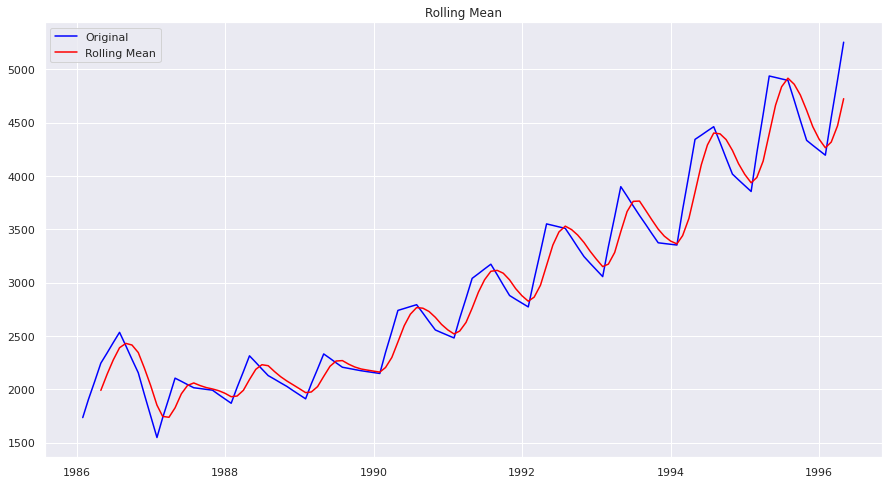

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [58]:
sales= pd.DataFrame()
from statsmodels.tsa.stattools import adfuller,acf,pacf
sales['Sales'] = month[['Sales']]
test_stationarity(sales)

#Augmented Dicky Fuller Test

In [59]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [60]:
adf_test(sales.Sales)

Fail to reject the null hypothesis
Data is non-stationary


#Feature Scaling (Transformations)

Square Root Transform

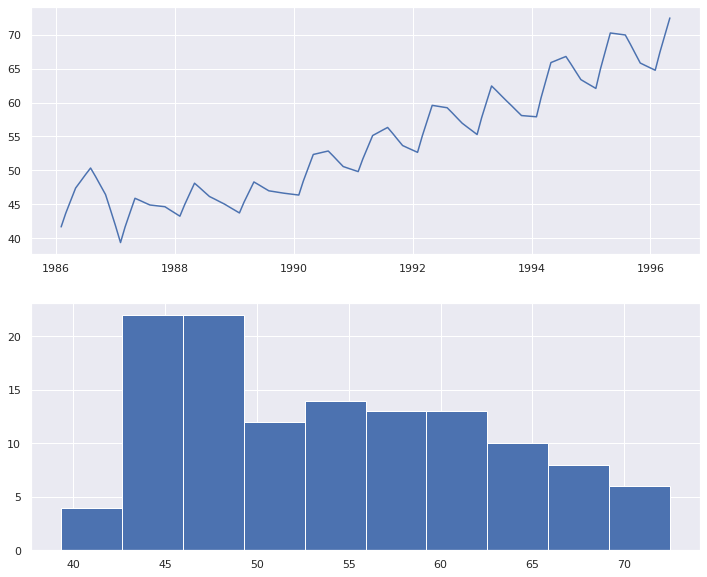

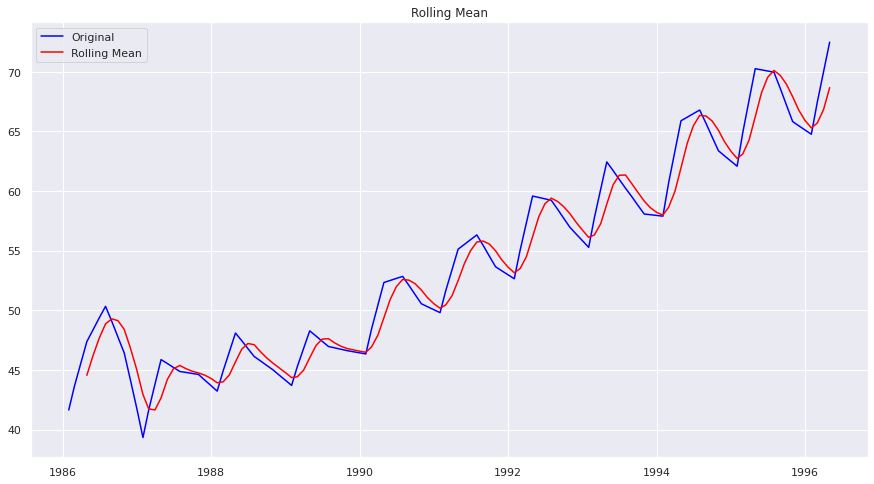

Results of Dickey Fuller Test:
Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [61]:
square_root= pd.DataFrame()
square_root = month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()

test_stationarity(square_root)

In [62]:
adf_test(square_root.Sales)

Fail to reject the null hypothesis
Data is non-stationary


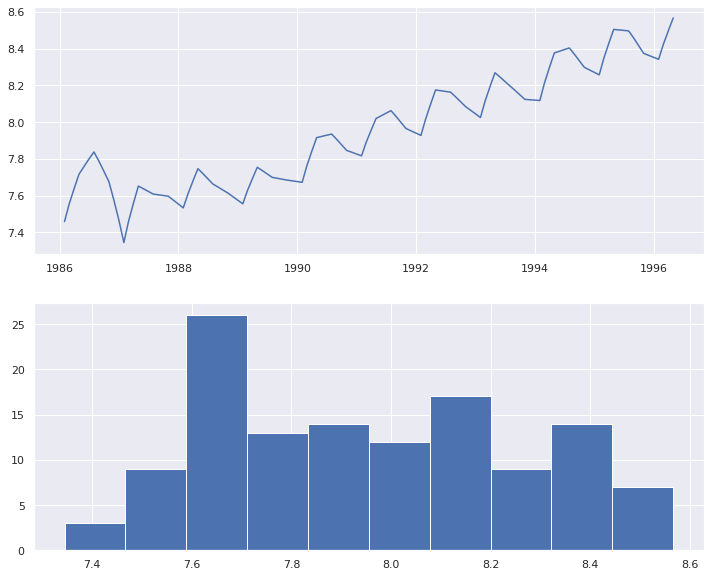

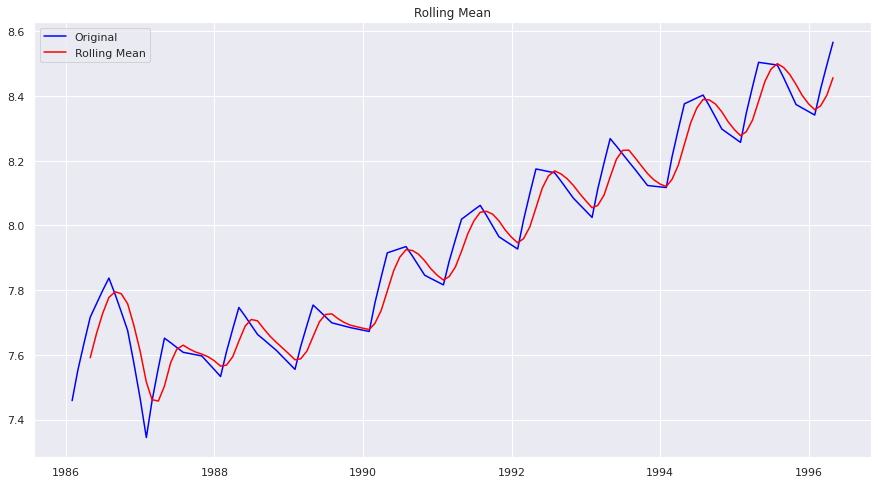

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [63]:
# Log Transform
log = pd.DataFrame()
log = month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])
#Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()

test_stationarity(log)

#Box Cox Transformation

,Sales
Date,
1986-01-31,7.458663
1986-02-28,7.552170
1986-03-31,7.637676
1986-04-30,7.716443
1986-05-31,7.758437


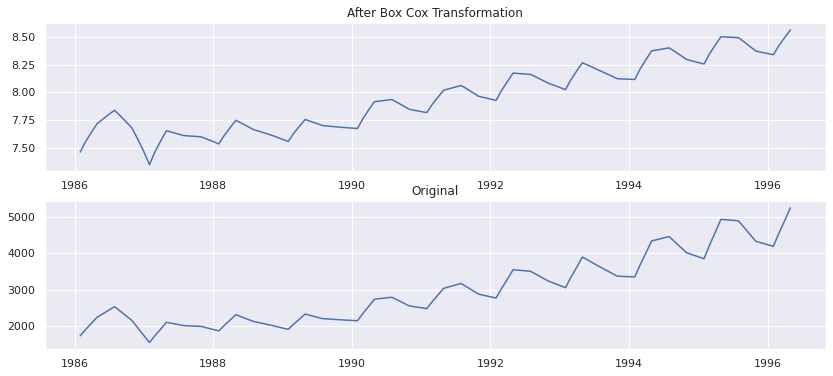

In [64]:
from scipy.stats import boxcox
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(month['Sales'], lmbda=0),month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(month, label='original')
axis[1].set_title('Original')
plt.show()

We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation.                                             
It is a horizontal trend.                                                  
The mean became constant. The mean is zero.                                
Also, the variance is almost constant.

#Differencing of the Box-Cox Transformation

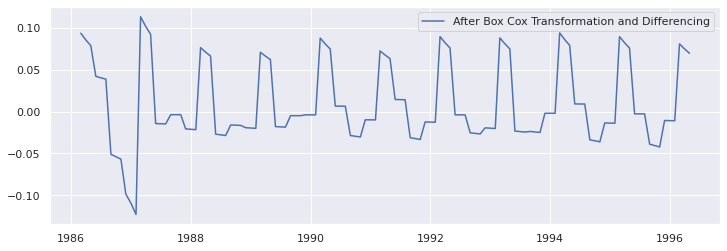

In [65]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

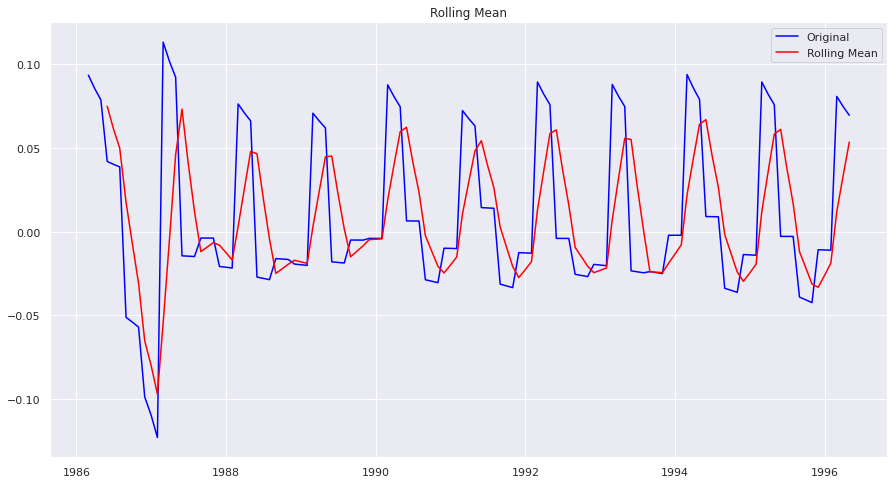

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [66]:
test_stationarity(data_boxcox_diff)

In [67]:
adf_test(data_boxcox_diff.Sales)

Reject the null hypothesis
Data is stationary


Finally, Our Series is now stationary for AR Forecasting

In [75]:
from statsmodels.tsa.arima_model import ARIMA

In [76]:
data_boxcox_diff.head()

,Sales
Date,
1986-02-28,0.093507
1986-03-31,0.085506
1986-04-30,0.078767
1986-05-31,0.041994
1986-06-30,0.040301


#Building The Time Series Forecasting with Optimal Value using ARIMA

In [77]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

In [78]:
model = ARIMA(train_data_boxcox_diff, order=(3,0,2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].add(data_boxcox.Sales[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast'])

In [82]:
# RMSE (Root Mean Squared Error)
rmse_ARIMA = np.sqrt(mean_squared_error(Test, y_hat_ar['ar_forecast'][Test.index.min():])).round(2)
rmse_ARIMA

521.48

In [83]:
#MAPE (Mean Absolute Percent Error)
mape_arima = MAPE(y_hat_ar['ar_forecast'],Test.Sales)
mape_arima

9.637526715332898

In [84]:
model_residual = model_fit.resid
model_residual.mean()

0.0006725109803326573

In [85]:
adf_test(model_residual)

Fail to reject the null hypothesis
Data is non-stationary


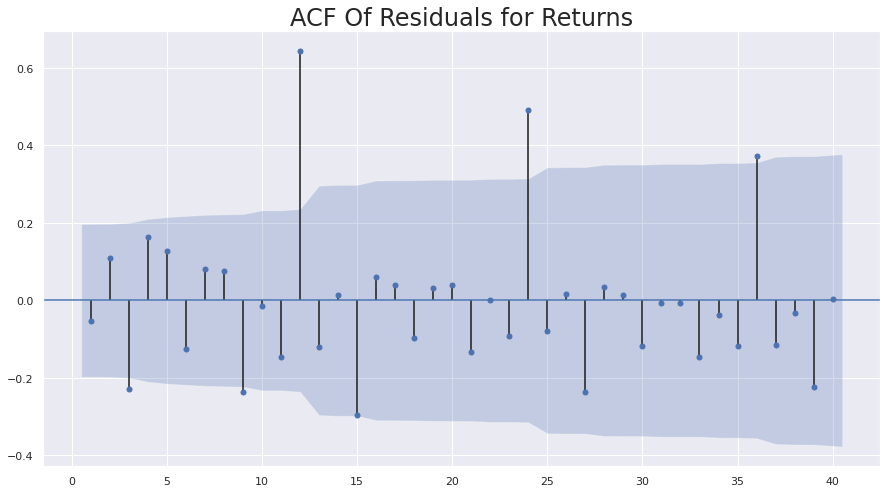

In [89]:
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

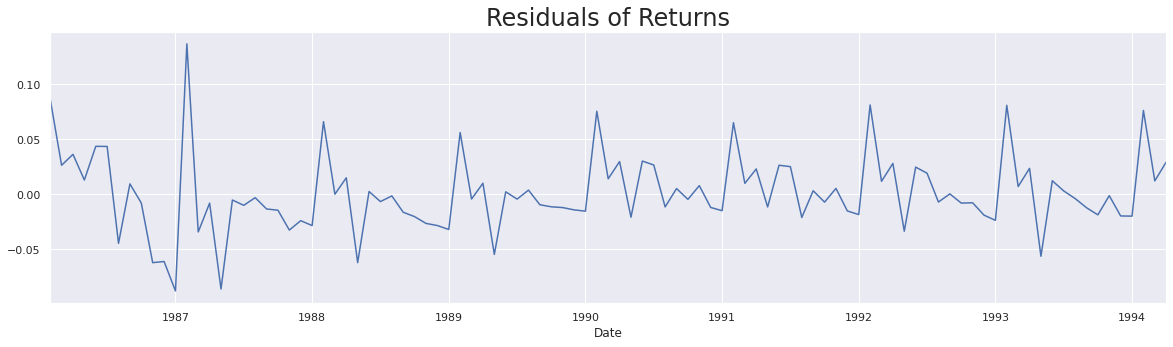

In [90]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()